# Fake Injection Purity and Efficiency analysis

DM-46624

Michael Wood-Vasey, <wmwv@pitt.edu>

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

import lsst.geom

import lsst.afw.image
from lsst.afw.math import Warper, WarperConfig
import lsst.afw.table

from lsst.ip.diffim import AlardLuptonSubtractConfig, AlardLuptonSubtractTask
from lsst.ip.diffim import GetTemplateConfig, GetTemplateTask
from lsst.ip.diffim import DetectAndMeasureConfig, DetectAndMeasureTask

In [2]:
afwDisplay.setDefaultBackend("firefly")

In [3]:
# Load collection
## Fakes run by Bruno Sanchez and Eric Bellm for DC2:
#repo = "/repo/dc2"
#collection = "u/ebellm/DM-46624/w_2024_40/DC2-with-injection"

## Fakes run by Bruno Sanchez for ComCam
repo = "/repo/embargo_new"
collection = "u/bos/ComCam/APWithFakes/DM-47227/LSSTComCam_ApPipeWithFakes_v6"

butler = Butler(repo, collections=collection)

In [4]:
band = "i"

datasetRefs_dia = butler.query_datasets("fakes_goodSeeingDiff_differenceExp", where=f"band='{band}'")

In [5]:
verbose = False
if verbose:
    for dr in datasetRefs_dia:
        print(dr)

print(f"\nFound {len(datasetRefs_dia)} differenceExps")


Found 45 differenceExps


In [6]:
i = 40
data_id = datasetRefs_dia[i].dataId
print(data_id)

{instrument: 'LSSTComCam', detector: 2, visit: 2024111700152, band: 'i', day_obs: 20241117, physical_filter: 'i_06'}


The standard data products are:

In [70]:
dia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler.get("calexp", dataId=data_id)
src = butler.get("src", dataId=data_id)
dia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id)  # SDM-ified table.  Does not containg sky sources

In [71]:
injected_dia = butler.get("fakes_goodSeeingDiff_differenceExp", dataId=data_id)
injected_template = butler.get("fakes_goodSeeingDiff_templateExp", dataId=data_id)
injected_calexp = butler.get("fakes_initial_pvi", dataId=data_id)
injected_dia_src = butler.get("fakes_goodSeeingDiff_diaSrc", dataId=data_id)
injected_dia_src_table = butler.get("fakes_goodSeeingDiff_diaSrcTable", dataId=data_id)  # SDM-ified table.  Does not containg sky sources
# Pre-matched tables
injected_match_dia_src_table = butler.get("fakes_goodSeeingDiff_matchDiaSourceTable", dataId=data_id)
injected_match_dia_src = butler.get("fakes_goodSeeingDiff_matchDiaSrc", dataId=data_id)

And the injected data products are:

In [72]:
# This is the catalog of the injected fakes in RA, Dec
injected_fakes = butler.get("fakes_initial_pvi_catalog", dataId=data_id)

In [78]:
afw_display = afwDisplay.Display(frame=1)

afw_display.setMaskTransparency(80)
afw_display.scale("asinh", -2, 5)
afw_display.mtv(template)

In [79]:
afw_display = afwDisplay.Display(frame=2)

afw_display.setMaskTransparency(80)
afw_display.scale("asinh", -2, 5)
afw_display.mtv(injected_calexp)

In [80]:
afw_display = afwDisplay.Display(frame=3)

afw_display.setMaskTransparency(100)
afw_display.scale("linear", "zscale")
afw_display.mtv(injected_dia)

In [17]:
snr_threshold = 5
max_science_snr = 300

# We're mixing columns from dia_src and dia_src_table
# This is dangerous.  I don't think there is a gaurantee that the ordering is the same.
# But I want the flags from dia_src and the science flux from dia_src_table

# 2024-12-06 MWV
#  There's some inconsistency between using the dia_src + dia_src_table and the dia_src_table only scores.
#  I think investigating this further and tracking down flags between dia_src and dia_src_table is worth doing

# 2024-12-04 MWV
#  There's some incompatibility that sometimes means that sky sources are in dia_src and sometimes they're not?

def good_sources(dia_src, dia_src_table, verbose=True):
    # Different versions of the pipeline have "sky_source" in dia_src or not
    # So we're just going to try except
    try:
        dia_src = dia_src[~dia_src["sky_source"]]
    except:
        pass
    
    # If I were doing just dia_src_table, I'd do something like this:
    just_dia_src_table = True
    if just_dia_src_table:
        good = (dia_src_table["snr"] > snr_threshold) & \
            ~dia_src_table["shape_flag"] & \
            ~dia_src_table["pixelFlags_bad"] & \
            ~dia_src_table["pixelFlags_cr"] & \
            ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr)
    else:
        good = ~dia_src["slot_Shape_flag"] & \
            (dia_src["base_PsfFlux_instFlux"] / dia_src["base_PsfFlux_instFluxErr"] > snr_threshold) & \
            ~dia_src["base_PixelFlags_flag_edge"] & \
            ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr) & \
            ~dia_src_table["pixelFlags_streak"]
    
    good_dia_src = dia_src_table[good].copy(deep=True)
    
    print(f"{len(good_dia_src)} good DIA sources found out of {len(dia_src)} detections.")
    
    return good_dia_src

In [18]:
good_dia_src = good_sources(dia_src, dia_src_table)

17 good DIA sources found out of 144 detections.


In [19]:
good_injected_dia_src = good_sources(injected_dia_src, injected_dia_src_table)

29 good DIA sources found out of 169 detections.


In [20]:
afw_display = afwDisplay.Display(frame=3)

for (x, y) in zip(good_injected_dia_src["x"], good_injected_dia_src["y"]):
    afw_display.dot("o", x, y, size=20, ctype="green")

In [ ]:
# [c for c in injected_match_dia_src if re.search("Flux", c)]

## Compare input fakes to dia_src

Translate RA, Dec to x, y from input injection catalog

In [21]:
wcs = calexp.getWcs()
from lsst import geom
coord = [geom.SpherePoint(r, d, geom.degrees) for r, d in zip(injected_fakes["ra"], injected_fakes["dec"])]
# The injected catalogs are in degrees.
x, y = wcs.skyToPixelArray(injected_fakes["ra"], injected_fakes["dec"], degrees=True)
injected_fakes["x"] = x
injected_fakes["y"] = y

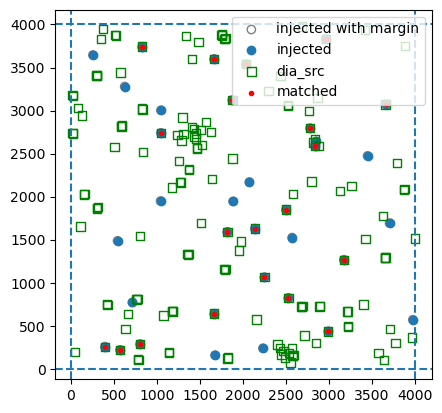

In [22]:
plt.scatter(injected_fakes["x"], injected_fakes["y"], edgecolor="gray", facecolor="none", label="injected with margin")
matched = injected_match_dia_src["diaSourceId"] > 0
plt.scatter(injected_match_dia_src["x_ssi"], injected_match_dia_src["y_ssi"], label="injected")
plt.scatter(injected_dia_src_table["x"], injected_dia_src_table["y"], color="green", facecolor="none", marker="s", label="dia_src")
plt.scatter(injected_match_dia_src[matched]["x_ssi"], injected_match_dia_src[matched]["y_ssi"], marker='.', color='red', label="matched")

plt.axvline(0, linestyle="--")
plt.axvline(4000, linestyle="--")
plt.axhline(0, linestyle="--")
plt.axhline(4000, linestyle="--")

plt.gca().set_aspect("equal")
plt.legend()

`injected_fakes` includes a slightly wider selection of simulated sources than fit in the detector.  `injected_match_dia_src` contains slightly fewer sources than fit in the detector.  We'll see this later when there are some `dia_src` objects on the edges that are not matched in `injected_match_dia_src`.

/tmp/ipykernel_8210/3417600234.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_8210/3417600234.py:12: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="injected")
/tmp/ipykernel_8210/3417600234.py:13: RuntimeWarning: invalid value encountered in divide
  ax[1].stairs(hm / h, bins, color="orange", label="matched")


Text(0, 0.5, 'fraction of recovered sources')

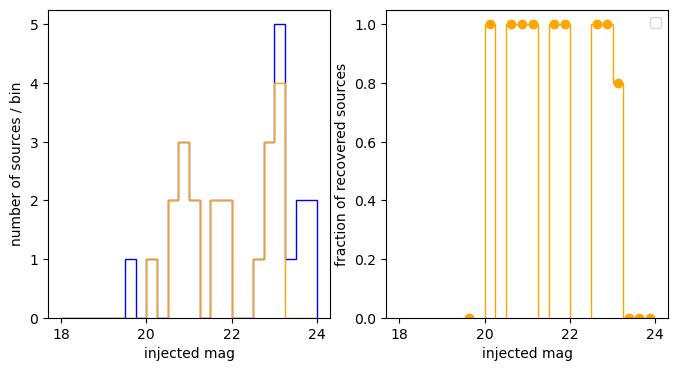

In [23]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

matched = injected_match_dia_src["diaSourceId"] > 0
bins = np.linspace(18, 24, 25)

h, _, _ = ax[0].hist(injected_match_dia_src["mag"], label="injected", histtype="step", color="blue", bins=bins)
hm, _, _ = ax[0].hist(injected_match_dia_src[matched]["mag"], label="good", histtype="step", color="orange", bins=bins)
ax[0].set_xlabel("injected mag")
ax[0].set_ylabel("number of sources / bin")
plt.legend()

ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="injected")
ax[1].stairs(hm / h, bins, color="orange", label="matched")
ax[1].set_xlabel("injected mag")
ax[1].set_ylabel("fraction of recovered sources")


Pull distribution sigma: 1.3418623417734308


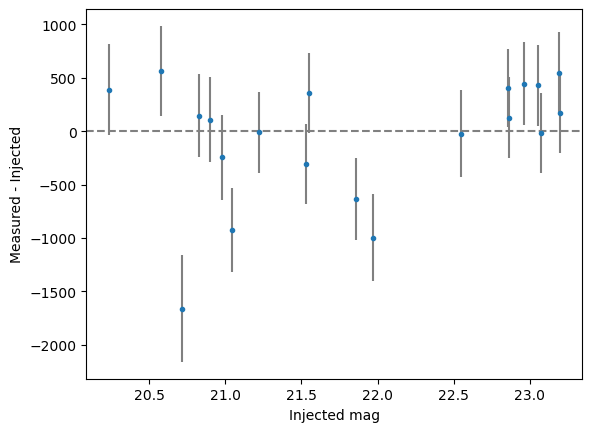

In [24]:
calib = injected_dia.getPhotoCalib()
recovered_mag = np.array([calib.instFluxToMagnitude(f) for f in injected_match_dia_src["psfFlux"]])
injected_flux = np.array([calib.magnitudeToInstFlux(m) for m in injected_match_dia_src["mag"]])
flux_residual = injected_match_dia_src["psfFlux"] - injected_flux
plt.errorbar(injected_match_dia_src["mag"], flux_residual, injected_match_dia_src["psfFluxErr"],
             linestyle="none", marker=".", ecolor="gray")
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Injected mag")
plt.ylabel("Measured - Injected")
sigma = np.std(flux_residual / injected_match_dia_src["psfFluxErr"])
print(f"Pull distribution sigma: {sigma}")


In [25]:
good_injected_match_dia_src = injected_match_dia_src.join(good_injected_dia_src[["diaSourceId"]].set_index("diaSourceId"), how="inner", on="diaSourceId", rsuffix=("dia_src")) #, validate="one_to_one")
print(len(good_injected_dia_src))

29


/tmp/ipykernel_8210/2846115888.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_8210/2846115888.py:13: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="matched")
/tmp/ipykernel_8210/2846115888.py:14: RuntimeWarning: invalid value encountered in divide
  ax[1].stairs(hm / h, bins, color="orange", label="matched")
/tmp/ipykernel_8210/2846115888.py:16: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:len(hg)] + bins[1:])/2, hg/h, linestyle="--", color="red", label="good matched")
/tmp/ipykernel_8210/2846115888.py:17: RuntimeWarning: invalid value encountered in divide
  ax[1].stairs(hg / h, bins, linestyle="--", color="red", label="matched")


Text(0, 0.5, 'fraction of recovered sources')

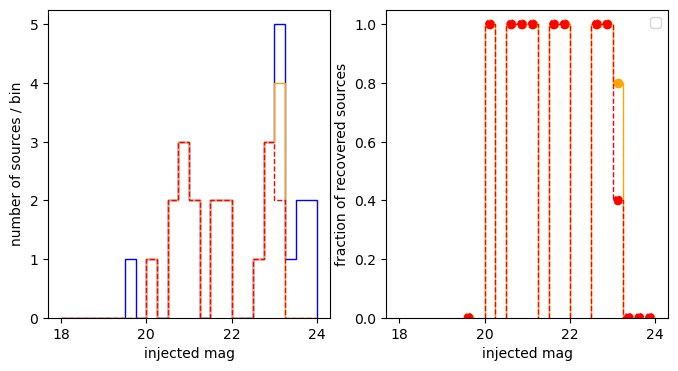

In [26]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

matched = injected_match_dia_src["diaSourceId"] > 0
bins = np.linspace(18, 24, 25)

h, _, _ = ax[0].hist(injected_match_dia_src["mag"], label="injected", histtype="step", color="blue", bins=bins)
hm, _, _ = ax[0].hist(injected_match_dia_src[matched]["mag"], label="matched", histtype="step", color="orange", bins=bins)
hg, _, _ = ax[0].hist(good_injected_match_dia_src["mag"], linestyle="--", label="good matched", histtype="step", color="red", bins=bins)
ax[0].set_xlabel("injected mag")
ax[0].set_ylabel("number of sources / bin")
plt.legend()

ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="matched")
ax[1].stairs(hm / h, bins, color="orange", label="matched")

ax[1].scatter((bins[:len(hg)] + bins[1:])/2, hg/h, linestyle="--", color="red", label="good matched")
ax[1].stairs(hg / h, bins, linestyle="--", color="red", label="matched")

ax[1].set_xlabel("injected mag")
ax[1].set_ylabel("fraction of recovered sources")


/tmp/ipykernel_8210/2846115888.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_8210/2846115888.py:13: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="matched")
/tmp/ipykernel_8210/2846115888.py:14: RuntimeWarning: invalid value encountered in divide
  ax[1].stairs(hm / h, bins, color="orange", label="matched")
/tmp/ipykernel_8210/2846115888.py:16: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:len(hg)] + bins[1:])/2, hg/h, linestyle="--", color="red", label="good matched")
/tmp/ipykernel_8210/2846115888.py:17: RuntimeWarning: invalid value encountered in divide
  ax[1].stairs(hg / h, bins, linestyle="--", color="red", label="matched")


Text(0, 0.5, 'fraction of recovered sources')

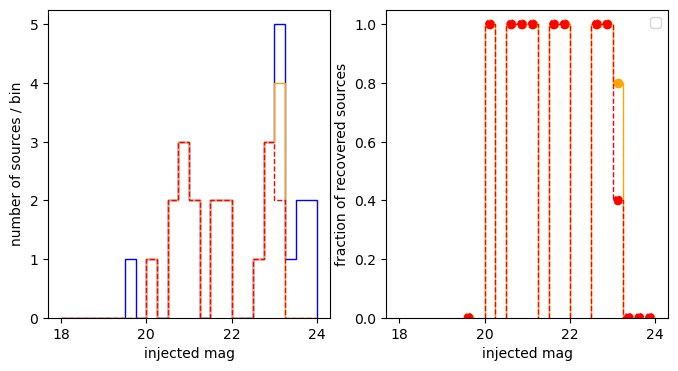

In [27]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

matched = injected_match_dia_src["diaSourceId"] > 0
bins = np.linspace(18, 24, 25)

h, _, _ = ax[0].hist(injected_match_dia_src["mag"], label="injected", histtype="step", color="blue", bins=bins)
hm, _, _ = ax[0].hist(injected_match_dia_src[matched]["mag"], label="matched", histtype="step", color="orange", bins=bins)
hg, _, _ = ax[0].hist(good_injected_match_dia_src["mag"], linestyle="--", label="good matched", histtype="step", color="red", bins=bins)
ax[0].set_xlabel("injected mag")
ax[0].set_ylabel("number of sources / bin")
plt.legend()

ax[1].scatter((bins[:len(hm)] + bins[1:])/2, hm/h, color="orange", label="matched")
ax[1].stairs(hm / h, bins, color="orange", label="matched")

ax[1].scatter((bins[:len(hg)] + bins[1:])/2, hg/h, linestyle="--", color="red", label="good matched")
ax[1].stairs(hg / h, bins, linestyle="--", color="red", label="matched")

ax[1].set_xlabel("injected mag")
ax[1].set_ylabel("fraction of recovered sources")


In [28]:
# [c for c in injected_match_dia_src.columns]

In [29]:
s = set(good_injected_dia_src["diaSourceId"])
t = set(injected_match_dia_src["diaSourceId"])

In [30]:
d = s - t
print(d)

{191192041147859104, 191192041147859106, 191192041147858949, 191192041147859014, 191192041147858951, 191192041147859019, 191192041147859020, 191192041147859024, 191192041147858993, 191192041147859027, 191192041147859037}


In [31]:
unmatched_dia = good_injected_dia_src.set_index("diaSourceId").loc[list(d)]

In [32]:
afw_display = afwDisplay.Display(frame=3)

# Injected + Detected that are unmatched
for (x, y) in zip(unmatched_dia["x"], unmatched_dia["y"]):
    afw_display.dot("o", x, y, size=20, ctype="orange")

# good_dia_src from un-injected subtraction
print(good_dia_src[["x", "y"]])
for (x, y) in zip(good_dia_src["x"], good_dia_src["y"]):
    afw_display.dot("sq", x, y, size=10, ctype="red")

               x            y
1     786.347570   103.987113
3    2488.575443   128.551495
8     443.118298   154.684619
17   2471.623395   212.784515
29   3215.369222   653.883986
30   1181.762098   664.082990
33   1188.332848   673.804849
44    773.882853   813.815695
60   1507.835591  1694.632610
62   1500.712843  1699.936126
63   3625.486627  1775.252378
65    311.599003  1880.362988
93   2882.665227  2661.045466
104   577.164040  2824.831258
110   122.230074  3012.164734
111  2754.762024  3000.060545
131  3877.968732  3749.653625


In [33]:
afw_display = afwDisplay.Display(frame=2)
afw_display.scale("linear", "zscale")


/tmp/ipykernel_8210/2266882866.py:22: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter((bins[:-1] + bins[1:])/2, ht/h, linestyle="--", color="green", label="detected")
/tmp/ipykernel_8210/2266882866.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].stairs(ht / h, bins, linestyle="--", linewidth=2, color="green", label="detected")
/tmp/ipykernel_8210/2266882866.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter((bins[:-1] + bins[1:])/2, hp/h, linestyle="--", color="purple", label="good detected")
/tmp/ipykernel_8210/2266882866.py:25: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter((bins[:-1] + bins[1:])/2, hp/h, linestyle="--", color="purple", label="good detected")
/tmp/ipykernel_8210/2266882866.py:26: RuntimeWarning: divide by zero encountered in divide
  ax[1].stairs(hp / h, bins, linestyle="--", linewidth=2, color="purple", label="good detected")
/tmp/ipykernel_8210/2266882866.py:26: RuntimeWarning: i

Text(0, 0.5, 'fraction of recovered sources')

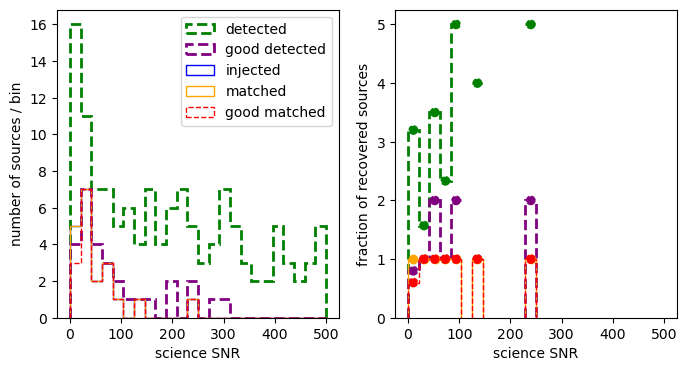

In [34]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

matched = injected_match_dia_src["diaSourceId"] > 0
bins = np.linspace(0, 500, 25)

ht, _, _ = ax[0].hist(injected_dia_src_table["scienceFlux"] / injected_dia_src_table["scienceFluxErr"], label="detected",
                      linestyle="--", linewidth=2, histtype="step", color="green", bins=bins)
hp, _, _ = ax[0].hist(good_injected_dia_src["scienceFlux"] / good_injected_dia_src["scienceFluxErr"], label="good detected",
                      linestyle="--", linewidth=2, histtype="step", color="purple", bins=bins)

h, _, _ = ax[0].hist(injected_match_dia_src["scienceFlux"] / injected_match_dia_src["scienceFluxErr"], label="injected",
                     histtype="step", color="blue", bins=bins)
hm, _, _ = ax[0].hist(injected_match_dia_src[matched]["scienceFlux"] / injected_match_dia_src[matched]["scienceFluxErr"], label="matched",
                      histtype="step", color="orange", bins=bins)
hg, _, _ = ax[0].hist(good_injected_match_dia_src["scienceFlux"] / good_injected_match_dia_src["scienceFluxErr"], linestyle="--", label="good matched",
                      histtype="step", color="red", bins=bins)
ax[0].set_xlabel("science SNR")
ax[0].set_ylabel("number of sources / bin")
plt.sca(ax[0])
plt.legend()

ax[1].scatter((bins[:-1] + bins[1:])/2, ht/h, linestyle="--", color="green", label="detected")
ax[1].stairs(ht / h, bins, linestyle="--", linewidth=2, color="green", label="detected")

ax[1].scatter((bins[:-1] + bins[1:])/2, hp/h, linestyle="--", color="purple", label="good detected")
ax[1].stairs(hp / h, bins, linestyle="--", linewidth=2, color="purple", label="good detected")

ax[1].scatter((bins[:-1] + bins[1:])/2, hm/h, color="orange", label="matched")
ax[1].stairs(hm / h, bins, color="orange", label="matched")

ax[1].scatter((bins[:-1] + bins[1:])/2, hg/h, linestyle="--", color="red", label="good matched")
ax[1].stairs(hg / h, bins, linestyle="--", color="red", label="matched")

ax[1].set_xlabel("science SNR")
ax[1].set_ylabel("fraction of recovered sources")

Note we have two different conceptual denominators here: all sources potentially in image vs the more conservative list in `injected_matched_dia_src`.  The `injected_dia_src` has all of the things detected on the image, including in the buffer region that's not included in `injected_matched_dia_src`.  So if you calculate an "efficiency" by dividing the number detected vs. injected in a magnitude band you will get an excess just from this.  You could also get a contribution to the excess from non-injection-related detection, whether real or artifacts; but the injection density is much higher than the detected dia source density without injection.

Some more work to figure out this matching would help clean up the understanding of the efficiency plot.  But the baseline is that we're recovering everyting.

The cutoff in SNR is because we imposed a specific cutoff to select "good" objects.

In [36]:
good_injected_dia_src['pixelFlags_injected']

4      False
6      False
18      True
20      True
22      True
27      True
35      True
47     False
52      True
53      True
57      True
68     False
69      True
70      True
72     False
73     False
74      True
77     False
80     False
90     False
98      True
111     True
116     True
130     True
131     True
141     True
144     True
151    False
153    False
Name: pixelFlags_injected, dtype: bool

In [48]:
??good_sources

Signature: good_sources(dia_src, dia_src_table, verbose=True)
Docstring: <no docstring>
Source:   
def good_sources(dia_src, dia_src_table, verbose=True):
    # Different versions of the pipeline have "sky_source" in dia_src or not
    # So we're just going to try except
    try:
        dia_src = dia_src[~dia_src["sky_source"]]
    except:
        pass
    
    # If I were doing just dia_src_table, I'd do something like this:
    just_dia_src_table = True
    if just_dia_src_table:
        good = (dia_src_table["snr"] > snr_threshold) & \
            ~dia_src_table["shape_flag"] & \
            ~dia_src_table["pixelFlags_bad"] & \
            ~dia_src_table["pixelFlags_cr"] & \
            ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr)
    else:
        good = ~dia_src["slot_Shape_flag"] & \
            (dia_src["base_PsfFlux_instFlux"] / dia_src["base_PsfFlux_instFluxErr"] > snr_threshold) & \
            ~dia_src["base_PixelFlags_flag_edge"] & \

In [46]:
evil_sources.columns

Index(['diaSourceId', 'visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'extendedness',
       'reliability', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'c

In [69]:
evil_sources=dia_src_table[(dia_src_table['x']<2600)&(dia_src_table['x']>2500)&(dia_src_table['y']<200)&(dia_src_table['y']>0)]
evil_sources[['x','y','shape_flag','centroid_flag','isDipole']]

,x,y,shape_flag,centroid_flag,isDipole
2,2550.000000,73.000000,True,True,False
7,2578.786019,145.591653,True,False,False
10,2572.000000,155.000000,True,True,False
11,2584.132771,156.042632,True,False,False
12,2531.000000,182.000000,True,True,False


In [55]:
np.sum(dia_src_table['pixelFlags_cr'])

0